In [34]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import os
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_svmlight_file
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm

# 数据路径
TRAIN_PATH = 'datasets/a9a.txt'
Validation_PATH = 'datasets/a9a.t.txt'

# 实验参数
INIT_METHODS = ['zeros', 'random', 'normal']
OPTIMIZERS = ['sgd', 'adam']
LEARNING_RATES = [0.01, 0.001]
BATCH_SIZES = [32, 64, 128]
N_ITERATIONS = 2000
EVAL_INTERVAL = 10


In [35]:
# 数据处理工具函数

def load_data(train_path, Validation_path, n_features=123):
    """
    加载训练集和测试集
    
    参数:
        train_path: 训练集路径
        Validation_path: 测试集路径
        n_features: 特征维度，默认为123
    
    返回:
        X_train: 训练集特征矩阵
        y_train: 训练集标签
        X_Validation: 测试集特征矩阵
        y_Validation: 测试集标签
    """
    # 加载训练集
    X_train, y_train = load_svmlight_file(train_path, n_features=n_features)
    # 加载测试集
    X_Validation, y_Validation = load_svmlight_file(Validation_path, n_features=n_features)
    
    # 将稀疏矩阵转换为密集矩阵
    X_train = X_train.toarray()
    X_Validation = X_Validation.toarray()
    
    # 添加偏置项
    X_train = np.c_[np.ones(X_train.shape[0]), X_train]
    X_Validation = np.c_[np.ones(X_Validation.shape[0]), X_Validation]
    
    # 将标签转换为+1和-1
    y_train[y_train == 0] = -1
    y_Validation[y_Validation == 0] = -1
    
    return X_train, y_train, X_Validation, y_Validation

def batch_iterator(X, y, batch_size):
    """
    生成批量数据的迭代器
    
    参数:
        X: 特征矩阵
        y: 标签
        batch_size: 批量大小
    
    返回:
        X_batch: 批量特征矩阵
        y_batch: 批量标签
    """
    n_samples = X.shape[0]
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start_idx in range(0, n_samples, batch_size):
        batch_indices = indices[start_idx:start_idx + batch_size]
        yield X[batch_indices], y[batch_indices]


In [36]:
# 优化器实现

class SGD:
    """
    随机梯度下降优化器
    """
    def __init__(self, learning_rate=0.01):
        """
        初始化SGD优化器
        
        参数:
            learning_rate: 学习率
        """
        self.learning_rate = learning_rate
    
    def update(self, w, grad):
        """
        更新参数
        
        参数:
            w: 当前参数
            grad: 梯度
        
        返回:
            w_updated: 更新后的参数
        """
        return w - self.learning_rate * grad


class Adam:
    """
    Adam优化器
    """
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        """
        初始化Adam优化器
        
        参数:
            learning_rate: 学习率
            beta1: 一阶矩估计的指数衰减率
            beta2: 二阶矩估计的指数衰减率
            epsilon: 小值，防止除零错误
        """
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = None  # 一阶矩估计
        self.v = None  # 二阶矩估计
        self.t = 0     # 时间步
    
    def update(self, w, grad):
        """
        更新参数
        
        参数:
            w: 当前参数
            grad: 梯度
        
        返回:
            w_updated: 更新后的参数
        """
        self.t += 1
        
        # 初始化动量项
        if self.m is None:
            self.m = np.zeros_like(w)
            self.v = np.zeros_like(w)
        
        # 更新偏置校正的一阶和二阶矩估计
        self.m = self.beta1 * self.m + (1 - self.beta1) * grad
        self.v = self.beta2 * self.v + (1 - self.beta2) * np.square(grad)
        
        # 计算偏置校正
        m_hat = self.m / (1 - self.beta1 ** self.t)
        v_hat = self.v / (1 - self.beta2 ** self.t)
        
        # 更新参数
        w_updated = w - self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)
        
        return w_updated


In [37]:
# 模型评估工具

def evaluate_model(y_true, y_pred):
    """
    评估模型性能
    
    参数:
        y_true: 真实标签
        y_pred: 预测标签
    
    返回:
        metrics: 包含各种评价指标的字典
    """
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    
    return metrics

def plot_training_history(history, title=None):
    """
    绘制训练历史记录
    
    参数:
        history: 包含损失值和准确率的字典
        title: 图表标题
    """
    plt.figure(figsize=(12, 5))
    
    # 绘制损失值
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    if 'Validation_loss' in history:
        plt.plot(history['Validation_loss'], label='Validation Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss over iterations')
    
    # 绘制准确率
    plt.subplot(1, 2, 2)
    plt.plot(history['train_accuracy'], label='Training Accuracy')
    if 'Validation_accuracy' in history:
        plt.plot(history['Validation_accuracy'], label='Validation Accuracy')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy over iterations')
    
    if title:
        plt.suptitle(title)
    plt.tight_layout()
    
    return plt


In [38]:
# 逻辑回归模型实现

class LogisticRegression:
    """
    逻辑回归模型
    """
    def __init__(self, input_dim, init_method='zeros', optimizer='sgd', learning_rate=0.01):
        """
        初始化逻辑回归模型
        
        参数:
            input_dim: 输入特征维度
            init_method: 参数初始化方法，可选 'zeros', 'random', 'normal'
            optimizer: 优化器类型，可选 'sgd', 'adam'
            learning_rate: 学习率
        """
        # 初始化参数
        if init_method == 'zeros':
            self.w = np.zeros(input_dim)
        elif init_method == 'random':
            self.w = np.random.random(input_dim) * 0.1
        elif init_method == 'normal':
            self.w = np.random.normal(0, 0.01, input_dim)
        else:
            raise ValueError("不支持的初始化方法")
        
        # 初始化优化器
        if optimizer == 'sgd':
            self.optimizer = SGD(learning_rate=learning_rate)
        elif optimizer == 'adam':
            self.optimizer = Adam(learning_rate=learning_rate)
        else:
            raise ValueError("不支持的优化器类型")
    
    def sigmoid(self, z):
        """
        sigmoid激活函数
        
        参数:
            z: 输入值
        
        返回:
            sigmoid(z)
        """
        # 使用截断避免溢出
        z = np.clip(z, -30, 30)
        return 1 / (1 + np.exp(-z))
    
    def forward(self, X):
        """
        前向传播
        
        参数:
            X: 输入特征
        
        返回:
            y_pred: 预测概率
        """
        z = np.dot(X, self.w)
        return self.sigmoid(z)
    
    def loss(self, y_true, y_pred):
        """
        计算损失函数值 (交叉熵损失)
        
        参数:
            y_true: 真实标签
            y_pred: 预测概率
        
        返回:
            loss: 损失函数值
        """
        # 避免对数中的0值
        eps = 1e-15
        y_pred = np.clip(y_pred, eps, 1 - eps)
        
        # 将y_true转换为二分类标签(0或1)
        y_binary = (y_true + 1) / 2
        
        # 计算交叉熵损失
        loss = -np.mean(y_binary * np.log(y_pred) + (1 - y_binary) * np.log(1 - y_pred))
        return loss
    
    def gradient(self, X, y_true, y_pred):
        """
        计算损失函数的梯度
        
        参数:
            X: 输入特征
            y_true: 真实标签
            y_pred: 预测概率
        
        返回:
            grad: 梯度
        """
        # 将y_true转换为二分类标签(0或1)
        y_binary = (y_true + 1) / 2
        
        # 计算梯度
        m = X.shape[0]
        grad = (1/m) * np.dot(X.T, (y_pred - y_binary))
        return grad
    
    def predict_proba(self, X):
        """
        预测概率
        
        参数:
            X: 输入特征
        
        返回:
            y_pred: 预测概率
        """
        return self.forward(X)
    
    def predict(self, X, threshold=0.5):
        """
        预测标签
        
        参数:
            X: 输入特征
            threshold: 阈值
        
        返回:
            y_pred: 预测标签 (-1或1)
        """
        y_proba = self.predict_proba(X)
        y_pred = np.where(y_proba >= threshold, 1, -1)
        return y_pred
    
    def train(self, X_train, y_train, X_Validation=None, y_Validation=None, 
              n_iterations=1000, batch_size=32, eval_interval=100):
        """
        训练模型
        
        参数:
            X_train: 训练集特征
            y_train: 训练集标签
            X_Validation: 测试集特征
            y_Validation: 测试集标签
            n_iterations: 迭代次数
            batch_size: 批量大小
            eval_interval: 评估间隔
            
        返回:
            history: 训练历史记录
        """
        history = {
            'train_loss': [],
            'train_accuracy': []
        }
        
        if X_Validation is not None and y_Validation is not None:
            history['Validation_loss'] = []
            history['Validation_accuracy'] = []
        
        for i in tqdm(range(n_iterations)):
            # 获取批量数据
            for X_batch, y_batch in batch_iterator(X_train, y_train, batch_size):
                # 前向传播
                y_pred = self.forward(X_batch)
                
                # 计算梯度
                grad = self.gradient(X_batch, y_batch, y_pred)
                
                # 更新参数
                self.w = self.optimizer.update(self.w, grad)
                break  # 每次迭代只使用一个批次
            
            # 定期评估模型
            if i % eval_interval == 0 or i == n_iterations - 1:
                # 评估训练集
                train_pred = self.predict(X_train)
                train_loss = self.loss(y_train, self.predict_proba(X_train))
                train_acc = np.mean(train_pred == y_train)
                
                history['train_loss'].append(train_loss)
                history['train_accuracy'].append(train_acc)
                
                # 评估测试集
                if X_Validation is not None and y_Validation is not None:
                    Validation_pred = self.predict(X_Validation)
                    Validation_loss = self.loss(y_Validation, self.predict_proba(X_Validation))
                    Validation_acc = np.mean(Validation_pred == y_Validation)
                    
                    history['Validation_loss'].append(Validation_loss)
                    history['Validation_accuracy'].append(Validation_acc)
        
        return history


In [39]:
# SVM模型实现

class SVM:
    """
    支持向量机模型
    """
    def __init__(self, input_dim, init_method='zeros', optimizer='sgd', learning_rate=0.01, C=1.0, loss_type='hinge'):
        """
        初始化SVM模型
        
        参数:
            input_dim: 输入特征维度
            init_method: 参数初始化方法，可选 'zeros', 'random', 'normal'
            optimizer: 优化器类型，可选 'sgd', 'adam'
            learning_rate: 学习率
            C: 正则化参数
            loss_type: 损失函数类型，可选 'hinge', 'squared_hinge'
        """
        # 初始化参数
        if init_method == 'zeros':
            self.w = np.zeros(input_dim)
        elif init_method == 'random':
            self.w = np.random.random(input_dim) * 0.1
        elif init_method == 'normal':
            self.w = np.random.normal(0, 0.01, input_dim)
        else:
            raise ValueError("不支持的初始化方法")
        
        # 初始化优化器
        if optimizer == 'sgd':
            self.optimizer = SGD(learning_rate=learning_rate)
        elif optimizer == 'adam':
            self.optimizer = Adam(learning_rate=learning_rate)
        else:
            raise ValueError("不支持的优化器类型")
        
        self.C = C  # 正则化参数
        self.loss_type = loss_type
    
    def compute_margin(self, X):
        """
        计算间隔
        
        参数:
            X: 输入特征
        
        返回:
            margin: 间隔
        """
        return np.dot(X, self.w)
    
    def loss(self, y_true, margin):
        """
        计算损失函数值
        
        参数:
            y_true: 真实标签
            margin: 间隔
        
        返回:
            loss: 损失函数值
        """
        if self.loss_type == 'hinge':
            # Hinge Loss: max(0, 1 - y*f(x))
            hinge_loss = np.maximum(0, 1 - y_true * margin)
            loss = np.mean(hinge_loss) + 0.5 * (1/self.C) * np.sum(self.w[1:]**2)
        
        elif self.loss_type == 'squared_hinge':
            # Squared Hinge Loss: max(0, 1 - y*f(x))^2
            hinge_loss = np.maximum(0, 1 - y_true * margin)
            loss = np.mean(hinge_loss**2) + 0.5 * (1/self.C) * np.sum(self.w[1:]**2)
        
        else:
            raise ValueError("不支持的损失函数类型")
        
        return loss
    
    def gradient(self, X, y_true, margin):
        """
        计算损失函数的梯度
        
        参数:
            X: 输入特征
            y_true: 真实标签
            margin: 间隔
        
        返回:
            grad: 梯度
        """
        m = X.shape[0]
        
        # 计算hinge loss的梯度
        if self.loss_type == 'hinge':
            # Hinge Loss梯度: -y_i * x_i if y_i * f(x_i) < 1 else 0
            mask = (y_true * margin) < 1
            d_hinge = np.zeros_like(margin)
            d_hinge[mask] = -y_true[mask]
            grad_hinge = (1/m) * np.dot(X.T, d_hinge)
        
        elif self.loss_type == 'squared_hinge':
            # Squared Hinge Loss梯度: -2 * (1 - y_i * f(x_i)) * y_i * x_i if y_i * f(x_i) < 1 else 0
            hinge = 1 - y_true * margin
            mask = hinge > 0
            d_hinge = np.zeros_like(margin)
            d_hinge[mask] = -2 * hinge[mask] * y_true[mask]
            grad_hinge = (1/m) * np.dot(X.T, d_hinge)
        
        else:
            raise ValueError("不支持的损失函数类型")
        
        # 添加L2正则化的梯度
        grad_reg = np.zeros_like(self.w)
        grad_reg[1:] = (1/self.C) * self.w[1:]
        
        return grad_hinge + grad_reg
    
    def predict(self, X, threshold=None):
        """
        预测标签
        
        参数:
            X: 输入特征
            threshold: 阈值，如果为None则使用0.0
        
        返回:
            y_pred: 预测标签 (-1或1)
        """
        scores = self.compute_margin(X)
        if threshold is None:
            threshold = 0.0
        y_pred = np.where(scores >= threshold, 1, -1)
        return y_pred
    
    def find_best_threshold(self, X_val, y_val):
        """
        通过搜索找到最佳阈值
        
        参数:
            X_val: 验证集特征
            y_val: 验证集标签
            
        返回:
            best_threshold: 最佳阈值
        """
        scores = self.compute_margin(X_val)
        
        # 尝试不同的阈值
        thresholds = np.percentile(scores, np.arange(0, 100, 5))
        best_accuracy = 0
        best_threshold = 0.0
        
        for threshold in thresholds:
            y_pred = np.where(scores >= threshold, 1, -1)
            accuracy = np.mean(y_pred == y_val)
            
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_threshold = threshold
                
        return best_threshold
    
    def train(self, X_train, y_train, X_Validation=None, y_Validation=None, 
              n_iterations=1000, batch_size=32, eval_interval=100):
        """
        训练模型
        
        参数:
            X_train: 训练集特征
            y_train: 训练集标签
            X_Validation: 测试集特征
            y_Validation: 测试集标签
            n_iterations: 迭代次数
            batch_size: 批量大小
            eval_interval: 评估间隔
            
        返回:
            history: 训练历史记录
        """
        history = {
            'train_loss': [],
            'train_accuracy': []
        }
        
        if X_Validation is not None and y_Validation is not None:
            history['Validation_loss'] = []
            history['Validation_accuracy'] = []
        
        for i in tqdm(range(n_iterations)):
            # 获取批量数据
            for X_batch, y_batch in batch_iterator(X_train, y_train, batch_size):
                # 计算间隔
                margin = self.compute_margin(X_batch)
                
                # 计算梯度
                grad = self.gradient(X_batch, y_batch, margin)
                
                # 更新参数
                self.w = self.optimizer.update(self.w, grad)
                break  # 每次迭代只使用一个批次
            
            # 定期评估模型
            if i % eval_interval == 0 or i == n_iterations - 1:
                # 评估训练集
                train_margin = self.compute_margin(X_train)
                train_loss = self.loss(y_train, train_margin)
                train_pred = self.predict(X_train)
                train_acc = np.mean(train_pred == y_train)
                
                history['train_loss'].append(train_loss)
                history['train_accuracy'].append(train_acc)
                
                # 评估测试集
                if X_Validation is not None and y_Validation is not None:
                    Validation_margin = self.compute_margin(X_Validation)
                    Validation_loss = self.loss(y_Validation, Validation_margin)
                    Validation_pred = self.predict(X_Validation)
                    Validation_acc = np.mean(Validation_pred == y_Validation)
                    
                    history['Validation_loss'].append(Validation_loss)
                    history['Validation_accuracy'].append(Validation_acc)
        
        return history


In [40]:
# 主实验函数

def run_logistic_regression_experiment():
    """
    运行逻辑回归实验
    """
    print("Loading data...")
    X_train, y_train, X_Validation, y_Validation = load_data(TRAIN_PATH, Validation_PATH)
    
    print("Running Logistic Regression experiments...")
    
    # 实验1：不同初始化方法
    init_histories = {}
    for init_method in INIT_METHODS:
        print(f"  Init method: {init_method}")
        lr = LogisticRegression(
            input_dim=X_train.shape[1],
            init_method=init_method,
            optimizer='sgd',
            learning_rate=0.01
        )
        history = lr.train(
            X_train, y_train, X_Validation, y_Validation,
            n_iterations=N_ITERATIONS,
            batch_size=32,
            eval_interval=EVAL_INTERVAL
        )
        init_histories[init_method] = history
    
    # 绘制不同初始化方法的结果
    plt.figure(figsize=(12, 10))
    
    # 训练损失
    plt.subplot(2, 2, 1)
    for init_method in INIT_METHODS:
        plt.plot(init_histories[init_method]['train_loss'], label=f'Training Loss ({init_method})')
    plt.xlabel('Evaluation Step')
    plt.ylabel('Loss')
    plt.title('Training Loss for Different Initialization Methods')
    plt.legend()
    
    # 测试损失
    plt.subplot(2, 2, 2)
    for init_method in INIT_METHODS:
        plt.plot(init_histories[init_method]['Validation_loss'], label=f'Validation Loss ({init_method})')
    plt.xlabel('Evaluation Step')
    plt.ylabel('Loss')
    plt.title('Validation Loss for Different Initialization Methods')
    plt.legend()
    
    # 训练准确率
    plt.subplot(2, 2, 3)
    for init_method in INIT_METHODS:
        plt.plot(init_histories[init_method]['train_accuracy'], label=f'Training Accuracy ({init_method})')
    plt.xlabel('Evaluation Step')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy for Different Initialization Methods')
    plt.legend()
    
    # 测试准确率
    plt.subplot(2, 2, 4)
    for init_method in INIT_METHODS:
        plt.plot(init_histories[init_method]['Validation_accuracy'], label=f'Validation Accuracy ({init_method})')
    plt.xlabel('Evaluation Step')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy for Different Initialization Methods')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('report/my_report/logistic_regression_init_methods.png')
    
    # 实验2：不同优化器
    opt_histories = {}
    for optimizer in OPTIMIZERS:
        print(f"  Optimizer: {optimizer}")
        lr = LogisticRegression(
            input_dim=X_train.shape[1],
            init_method='normal',
            optimizer=optimizer,
            learning_rate=0.01 if optimizer == 'sgd' else 0.001
        )
        history = lr.train(
            X_train, y_train, X_Validation, y_Validation,
            n_iterations=N_ITERATIONS,
            batch_size=32,
            eval_interval=EVAL_INTERVAL
        )
        opt_histories[optimizer] = history
    
    # 绘制不同优化器的结果
    plt.figure(figsize=(12, 10))
    
    # 训练损失
    plt.subplot(2, 2, 1)
    for optimizer in OPTIMIZERS:
        plt.plot(opt_histories[optimizer]['train_loss'], label=f'Training Loss ({optimizer})')
    plt.xlabel('Evaluation Step')
    plt.ylabel('Loss')
    plt.title('Training Loss for Different Optimizers')
    plt.legend()
    
    # 测试损失
    plt.subplot(2, 2, 2)
    for optimizer in OPTIMIZERS:
        plt.plot(opt_histories[optimizer]['Validation_loss'], label=f'Validation Loss ({optimizer})')
    plt.xlabel('Evaluation Step')
    plt.ylabel('Loss')
    plt.title('Validation Loss for Different Optimizers')
    plt.legend()
    
    # 训练准确率
    plt.subplot(2, 2, 3)
    for optimizer in OPTIMIZERS:
        plt.plot(opt_histories[optimizer]['train_accuracy'], label=f'Training Accuracy ({optimizer})')
    plt.xlabel('Evaluation Step')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy for Different Optimizers')
    plt.legend()
    
    # 测试准确率
    plt.subplot(2, 2, 4)
    for optimizer in OPTIMIZERS:
        plt.plot(opt_histories[optimizer]['Validation_accuracy'], label=f'Validation Accuracy ({optimizer})')
    plt.xlabel('Evaluation Step')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy for Different Optimizers')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('report/my_report/logistic_regression_optimizers.png')
    
    # 实验3：不同批量大小
    batch_histories = {}
    for batch_size in BATCH_SIZES:
        print(f"  Batch size: {batch_size}")
        lr = LogisticRegression(
            input_dim=X_train.shape[1],
            init_method='normal',
            optimizer='adam',
            learning_rate=0.001
        )
        history = lr.train(
            X_train, y_train, X_Validation, y_Validation,
            n_iterations=N_ITERATIONS,
            batch_size=batch_size,
            eval_interval=EVAL_INTERVAL
        )
        batch_histories[batch_size] = history
    
    # 绘制不同批量大小的结果
    plt.figure(figsize=(12, 10))
    
    # 训练损失
    plt.subplot(2, 2, 1)
    for batch_size in BATCH_SIZES:
        plt.plot(batch_histories[batch_size]['train_loss'], label=f'Training Loss (batch={batch_size})')
    plt.xlabel('Evaluation Step')
    plt.ylabel('Loss')
    plt.title('Training Loss for Different Batch Sizes')
    plt.legend()
    
    # 测试损失
    plt.subplot(2, 2, 2)
    for batch_size in BATCH_SIZES:
        plt.plot(batch_histories[batch_size]['Validation_loss'], label=f'Validation Loss (batch={batch_size})')
    plt.xlabel('Evaluation Step')
    plt.ylabel('Loss')
    plt.title('Validation Loss for Different Batch Sizes')
    plt.legend()
    
    # 训练准确率
    plt.subplot(2, 2, 3)
    for batch_size in BATCH_SIZES:
        plt.plot(batch_histories[batch_size]['train_accuracy'], label=f'Training Accuracy (batch={batch_size})')
    plt.xlabel('Evaluation Step')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy for Different Batch Sizes')
    plt.legend()
    
    # 测试准确率
    plt.subplot(2, 2, 4)
    for batch_size in BATCH_SIZES:
        plt.plot(batch_histories[batch_size]['Validation_accuracy'], label=f'Validation Accuracy (batch={batch_size})')
    plt.xlabel('Evaluation Step')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy for Different Batch Sizes')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('report/my_report/logistic_regression_batch_sizes.png')

def run_svm_experiment():
    """
    运行SVM实验
    """
    print("Loading data...")
    X_train, y_train, X_Validation, y_Validation = load_data(TRAIN_PATH, Validation_PATH)
    
    print("Running SVM experiments...")
    
    # 实验1：不同初始化方法
    init_histories = {}
    for init_method in INIT_METHODS:
        print(f"  Init method: {init_method}")
        svm = SVM(
            input_dim=X_train.shape[1],
            init_method=init_method,
            optimizer='sgd',
            learning_rate=0.01,
            C=1.0,
            loss_type='hinge'
        )
        history = svm.train(
            X_train, y_train, X_Validation, y_Validation,
            n_iterations=N_ITERATIONS,
            batch_size=32,
            eval_interval=EVAL_INTERVAL
        )
        init_histories[init_method] = history
    
    # 绘制不同初始化方法的结果
    plt.figure(figsize=(12, 10))
    
    # 训练损失
    plt.subplot(2, 2, 1)
    for init_method in INIT_METHODS:
        plt.plot(init_histories[init_method]['train_loss'], label=f'Training Loss ({init_method})')
    plt.xlabel('Evaluation Step')
    plt.ylabel('Loss')
    plt.title('Training Loss for Different Initialization Methods')
    plt.legend()
    
    # 测试损失
    plt.subplot(2, 2, 2)
    for init_method in INIT_METHODS:
        plt.plot(init_histories[init_method]['Validation_loss'], label=f'Validation Loss ({init_method})')
    plt.xlabel('Evaluation Step')
    plt.ylabel('Loss')
    plt.title('Validation Loss for Different Initialization Methods')
    plt.legend()
    
    # 训练准确率
    plt.subplot(2, 2, 3)
    for init_method in INIT_METHODS:
        plt.plot(init_histories[init_method]['train_accuracy'], label=f'Training Accuracy ({init_method})')
    plt.xlabel('Evaluation Step')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy for Different Initialization Methods')
    plt.legend()
    
    # 测试准确率
    plt.subplot(2, 2, 4)
    for init_method in INIT_METHODS:
        plt.plot(init_histories[init_method]['Validation_accuracy'], label=f'Validation Accuracy ({init_method})')
    plt.xlabel('Evaluation Step')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy for Different Initialization Methods')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('report/my_report/svm_init_methods.png')
    
    # 实验2：不同优化器
    opt_histories = {}
    for optimizer in OPTIMIZERS:
        print(f"  Optimizer: {optimizer}")
        svm = SVM(
            input_dim=X_train.shape[1],
            init_method='normal',
            optimizer=optimizer,
            learning_rate=0.01 if optimizer == 'sgd' else 0.001,
            C=1.0,
            loss_type='hinge'
        )
        history = svm.train(
            X_train, y_train, X_Validation, y_Validation,
            n_iterations=N_ITERATIONS,
            batch_size=32,
            eval_interval=EVAL_INTERVAL
        )
        opt_histories[optimizer] = history
    
    # 绘制不同优化器的结果
    plt.figure(figsize=(12, 10))
    
    # 训练损失
    plt.subplot(2, 2, 1)
    for optimizer in OPTIMIZERS:
        plt.plot(opt_histories[optimizer]['train_loss'], label=f'Training Loss ({optimizer})')
    plt.xlabel('Evaluation Step')
    plt.ylabel('Loss')
    plt.title('Training Loss for Different Optimizers')
    plt.legend()
    
    # 测试损失
    plt.subplot(2, 2, 2)
    for optimizer in OPTIMIZERS:
        plt.plot(opt_histories[optimizer]['Validation_loss'], label=f'Validation Loss ({optimizer})')
    plt.xlabel('Evaluation Step')
    plt.ylabel('Loss')
    plt.title('Validation Loss for Different Optimizers')
    plt.legend()
    
    # 训练准确率
    plt.subplot(2, 2, 3)
    for optimizer in OPTIMIZERS:
        plt.plot(opt_histories[optimizer]['train_accuracy'], label=f'Training Accuracy ({optimizer})')
    plt.xlabel('Evaluation Step')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy for Different Optimizers')
    plt.legend()
    
    # 测试准确率
    plt.subplot(2, 2, 4)
    for optimizer in OPTIMIZERS:
        plt.plot(opt_histories[optimizer]['Validation_accuracy'], label=f'Validation Accuracy ({optimizer})')
    plt.xlabel('Evaluation Step')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy for Different Optimizers')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('report/my_report/svm_optimizers.png')
    
    # 实验3：不同损失函数
    loss_types = ['hinge', 'squared_hinge']
    loss_histories = {}
    for loss_type in loss_types:
        print(f"  Loss type: {loss_type}")
        svm = SVM(
            input_dim=X_train.shape[1],
            init_method='normal',
            optimizer='adam',
            learning_rate=0.001,
            C=1.0,
            loss_type=loss_type
        )
        history = svm.train(
            X_train, y_train, X_Validation, y_Validation,
            n_iterations=N_ITERATIONS,
            batch_size=32,
            eval_interval=EVAL_INTERVAL
        )
        loss_histories[loss_type] = history
    
    # 绘制不同损失函数的结果
    plt.figure(figsize=(12, 10))
    
    # 训练损失
    plt.subplot(2, 2, 1)
    for loss_type in loss_types:
        plt.plot(loss_histories[loss_type]['train_loss'], label=f'Training Loss ({loss_type})')
    plt.xlabel('Evaluation Step')
    plt.ylabel('Loss')
    plt.title('Training Loss for Different Loss Functions')
    plt.legend()
    
    # 测试损失
    plt.subplot(2, 2, 2)
    for loss_type in loss_types:
        plt.plot(loss_histories[loss_type]['Validation_loss'], label=f'Validation Loss ({loss_type})')
    plt.xlabel('Evaluation Step')
    plt.ylabel('Loss')
    plt.title('Validation Loss for Different Loss Functions')
    plt.legend()
    
    # 训练准确率
    plt.subplot(2, 2, 3)
    for loss_type in loss_types:
        plt.plot(loss_histories[loss_type]['train_accuracy'], label=f'Training Accuracy ({loss_type})')
    plt.xlabel('Evaluation Step')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy for Different Loss Functions')
    plt.legend()
    
    # 测试准确率
    plt.subplot(2, 2, 4)
    for loss_type in loss_types:
        plt.plot(loss_histories[loss_type]['Validation_accuracy'], label=f'Validation Accuracy ({loss_type})')
    plt.xlabel('Evaluation Step')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy for Different Loss Functions')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('report/my_report/svm_loss_functions.png')

def compare_logistic_regression_and_svm():
    """
    比较逻辑回归和SVM
    """
    print("Loading data...")
    X_train, y_train, X_Validation, y_Validation = load_data(TRAIN_PATH, Validation_PATH)
    
    print("Running comparison between Logistic Regression and SVM...")
    
    # 逻辑回归
    print("  Training Logistic Regression...")
    lr = LogisticRegression(
        input_dim=X_train.shape[1],
        init_method='normal',
        optimizer='adam',
        learning_rate=0.001
    )
    lr_history = lr.train(
        X_train, y_train, X_Validation, y_Validation,
        n_iterations=N_ITERATIONS,
        batch_size=32,
        eval_interval=EVAL_INTERVAL
    )
    
    # SVM - 使用更合理的参数配置
    print("  Training SVM...")
    svm = SVM(
        input_dim=X_train.shape[1],
        init_method='normal',
        optimizer='adam',
        learning_rate=0.001,
        C=10.0,  # 增加C值以减少正则化强度
        loss_type='hinge'
    )
    svm_history = svm.train(
        X_train, y_train, X_Validation, y_Validation,
        n_iterations=N_ITERATIONS,
        batch_size=32,
        eval_interval=EVAL_INTERVAL
    )
    
    # 绘制比较结果
    plt.figure(figsize=(12, 10))
    
    # 训练损失
    plt.subplot(2, 2, 1)
    plt.plot(lr_history['train_loss'], label='Logistic Regression')
    plt.plot(svm_history['train_loss'], label='SVM')
    plt.xlabel('Evaluation Step')
    plt.ylabel('Loss')
    plt.title('Training Loss Comparison')
    plt.legend()
    
    # 测试损失
    plt.subplot(2, 2, 2)
    plt.plot(lr_history['Validation_loss'], label='Logistic Regression')
    plt.plot(svm_history['Validation_loss'], label='SVM')
    plt.xlabel('Evaluation Step')
    plt.ylabel('Loss')
    plt.title('Validation Loss Comparison')
    plt.legend()
    
    # 训练准确率
    plt.subplot(2, 2, 3)
    plt.plot(lr_history['train_accuracy'], label='Logistic Regression')
    plt.plot(svm_history['train_accuracy'], label='SVM')
    plt.xlabel('Evaluation Step')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy Comparison')
    plt.legend()
    
    # 测试准确率
    plt.subplot(2, 2, 4)
    plt.plot(lr_history['Validation_accuracy'], label='Logistic Regression')
    plt.plot(svm_history['Validation_accuracy'], label='SVM')
    plt.xlabel('Evaluation Step')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy Comparison')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('report/my_report/lr_vs_svm_comparison.png')
    
    # 评估最终模型性能
    print("Final Logistic Regression performance on Validation set:")
    lr_pred = lr.predict(X_Validation)
    lr_metrics = evaluate_model(y_Validation, lr_pred)
    print(f"  Accuracy: {lr_metrics['accuracy']:.4f}")
    print(f"  Precision: {lr_metrics['precision']:.4f}")
    print(f"  Recall: {lr_metrics['recall']:.4f}")
    print(f"  F1 Score: {lr_metrics['f1']:.4f}")
    
    # 为SVM找到最佳阈值
    print("Finding best threshold for SVM...")
    # 使用训练集的一部分作为验证集来找最佳阈值
    # 这里使用20%的训练数据
    val_size = int(0.2 * len(X_train))
    indices = np.random.permutation(len(X_train))
    X_val, y_val = X_train[indices[:val_size]], y_train[indices[:val_size]]
    
    best_threshold = svm.find_best_threshold(X_val, y_val)
    print(f"  Best threshold: {best_threshold:.4f}")
    
    print("Final SVM performance on Validation set:")
    svm_pred = svm.predict(X_Validation, threshold=best_threshold)
    svm_metrics = evaluate_model(y_Validation, svm_pred)
    print(f"  Accuracy: {svm_metrics['accuracy']:.4f}")
    print(f"  Precision: {svm_metrics['precision']:.4f}")
    print(f"  Recall: {svm_metrics['recall']:.4f}")
    print(f"  F1 Score: {svm_metrics['f1']:.4f}")


开始逻辑回归实验...
Loading data...
Running Logistic Regression experiments...
  Init method: zeros


100%|██████████| 2000/2000 [00:04<00:00, 421.79it/s] 


  Init method: random


100%|██████████| 2000/2000 [00:01<00:00, 1077.28it/s]


  Init method: normal


100%|██████████| 2000/2000 [00:01<00:00, 1239.02it/s]


  Optimizer: sgd


100%|██████████| 2000/2000 [00:05<00:00, 362.05it/s]


  Optimizer: adam


100%|██████████| 2000/2000 [00:02<00:00, 739.81it/s]


  Batch size: 32


100%|██████████| 2000/2000 [00:03<00:00, 500.25it/s]


  Batch size: 64


100%|██████████| 2000/2000 [00:02<00:00, 750.09it/s]


  Batch size: 128


100%|██████████| 2000/2000 [00:03<00:00, 533.13it/s]



开始SVM实验...
Loading data...
Running SVM experiments...
  Init method: zeros


100%|██████████| 2000/2000 [00:03<00:00, 615.39it/s] 


  Init method: random


100%|██████████| 2000/2000 [00:02<00:00, 707.14it/s] 


  Init method: normal


100%|██████████| 2000/2000 [00:01<00:00, 1106.28it/s]


  Optimizer: sgd


100%|██████████| 2000/2000 [00:04<00:00, 431.26it/s]


  Optimizer: adam


100%|██████████| 2000/2000 [00:05<00:00, 365.40it/s] 


  Loss type: hinge


100%|██████████| 2000/2000 [00:07<00:00, 279.11it/s]


  Loss type: squared_hinge


100%|██████████| 2000/2000 [00:01<00:00, 1087.05it/s]



比较逻辑回归和SVM...
Loading data...
Running comparison between Logistic Regression and SVM...
  Training Logistic Regression...


100%|██████████| 2000/2000 [00:04<00:00, 439.08it/s]


  Training SVM...


100%|██████████| 2000/2000 [00:01<00:00, 1252.58it/s]


Final Logistic Regression performance on Validation set:
  Accuracy: 0.8476
  Precision: 0.7238
  Recall: 0.5736
  F1 Score: 0.6400
Finding best threshold for SVM...
  Best threshold: -0.4682
Final SVM performance on Validation set:
  Accuracy: 0.8383
  Precision: 0.7536
  Recall: 0.4691
  F1 Score: 0.5782

所有实验完成！总用时: 1.05 分钟


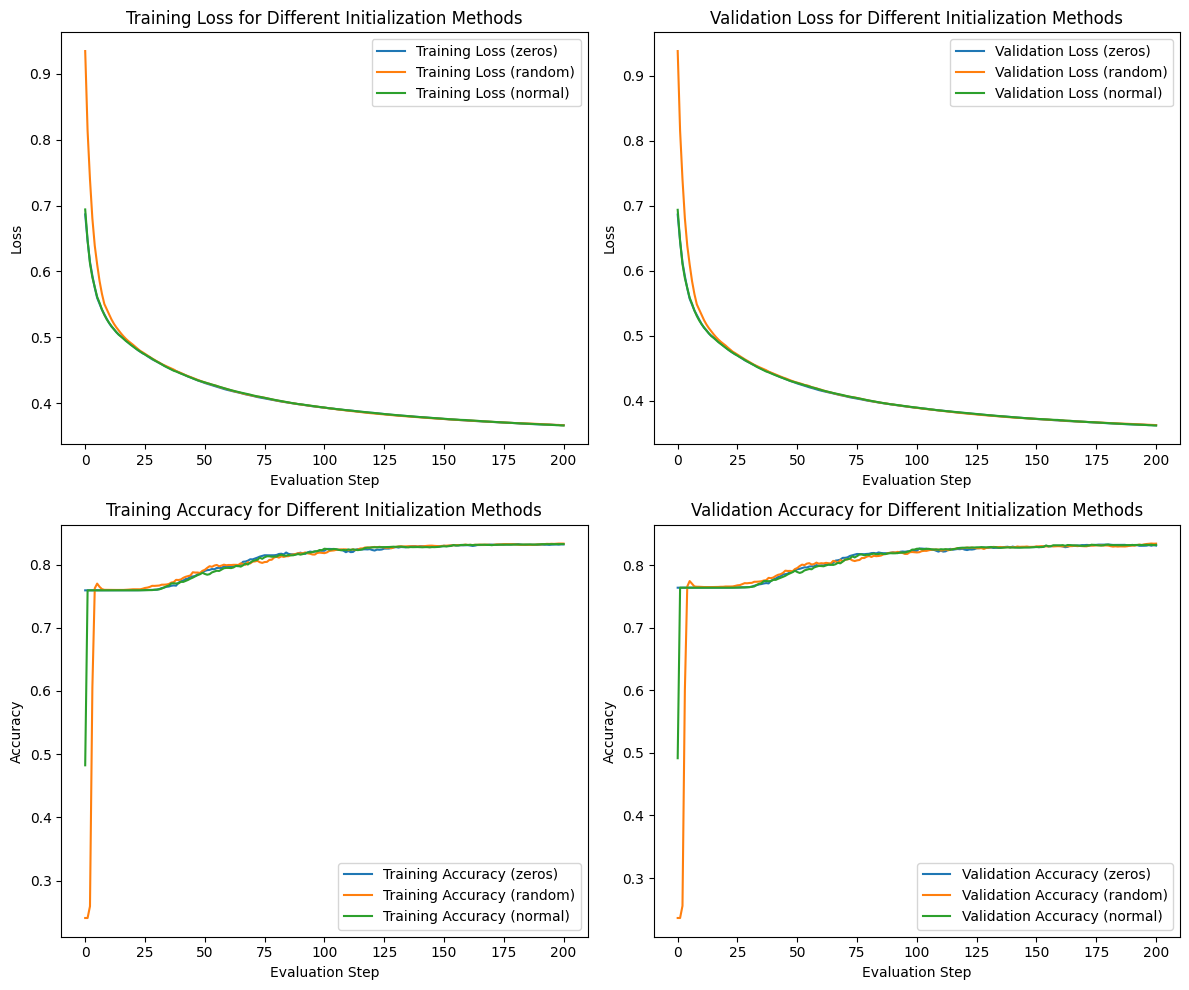

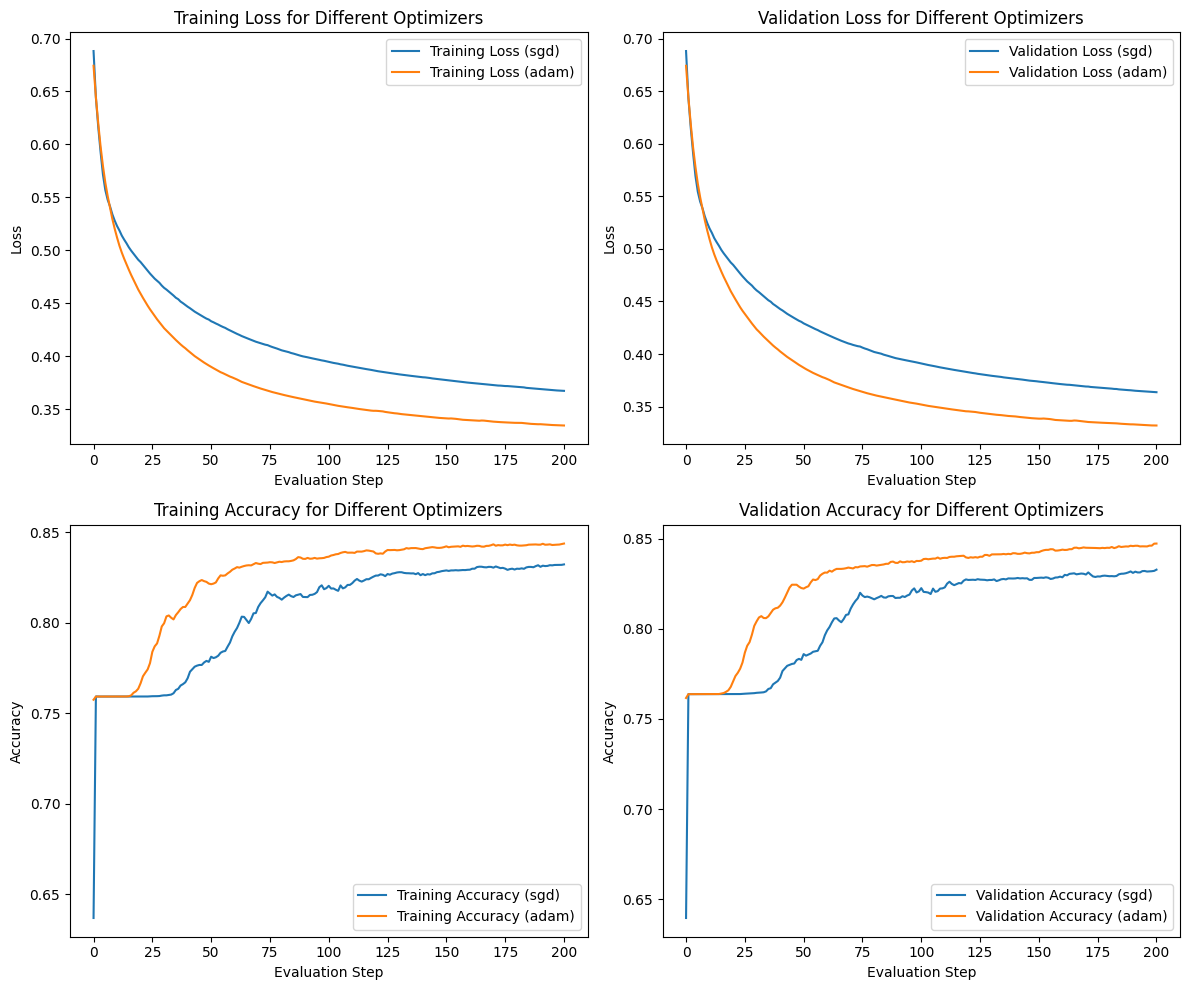

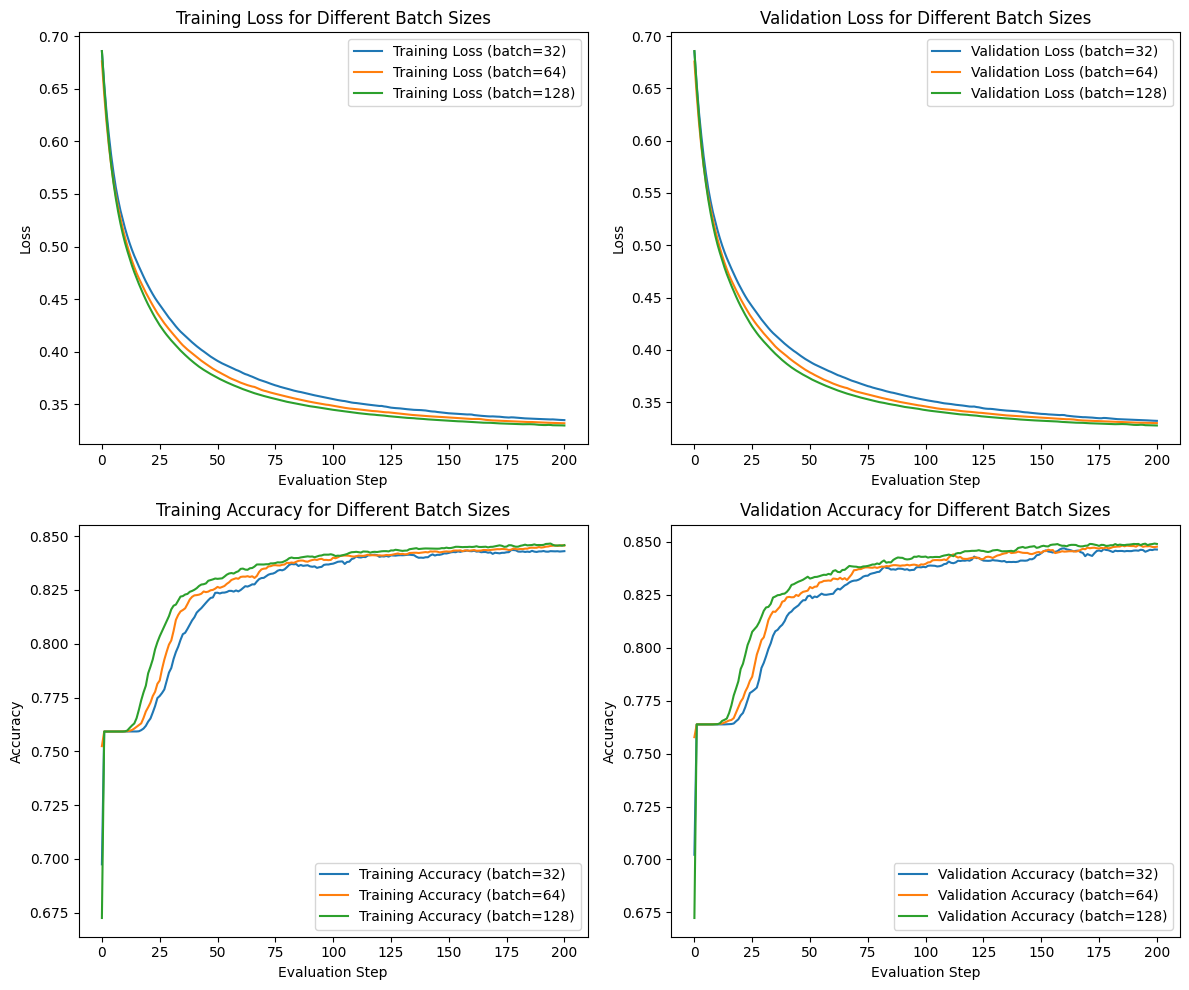

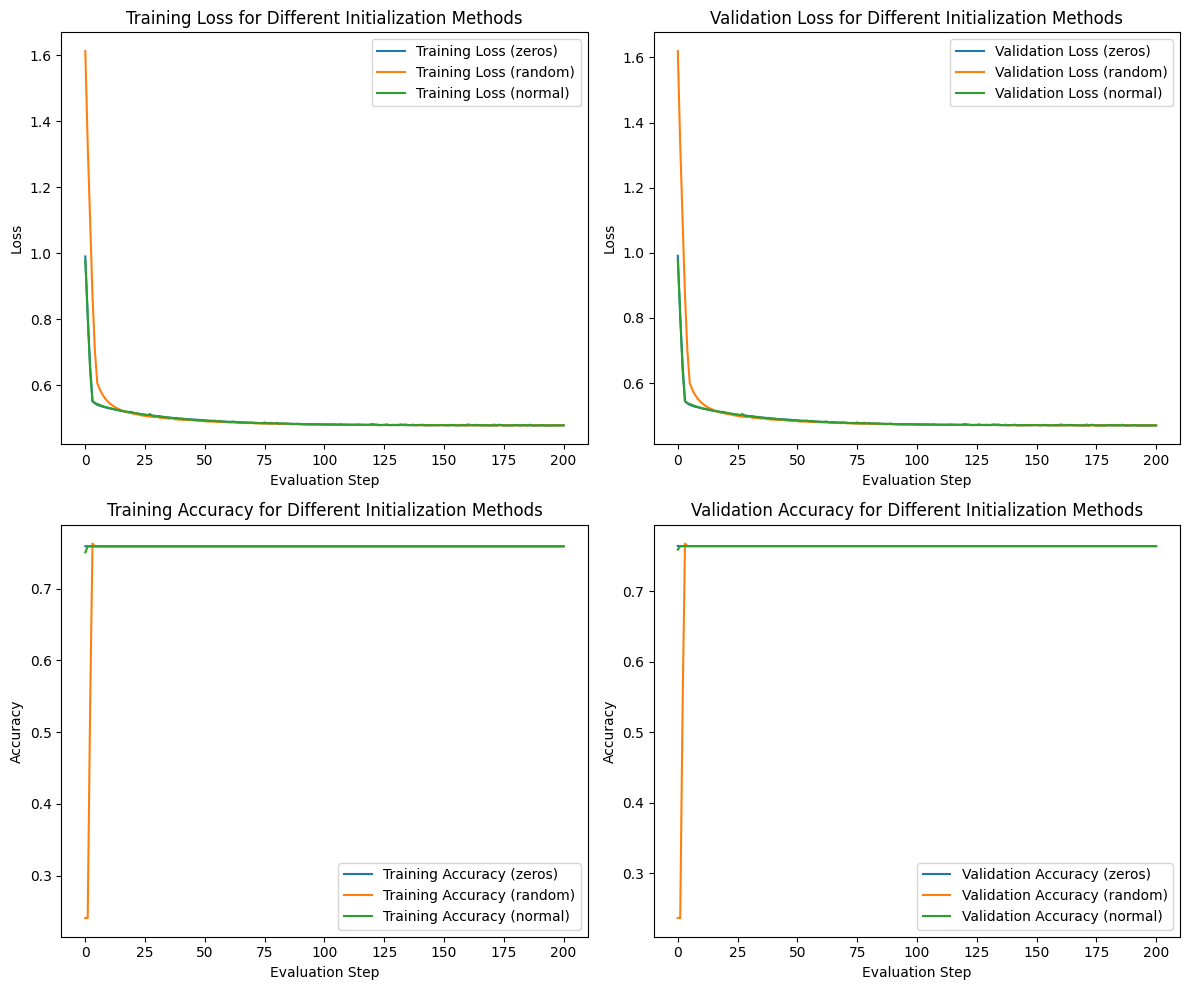

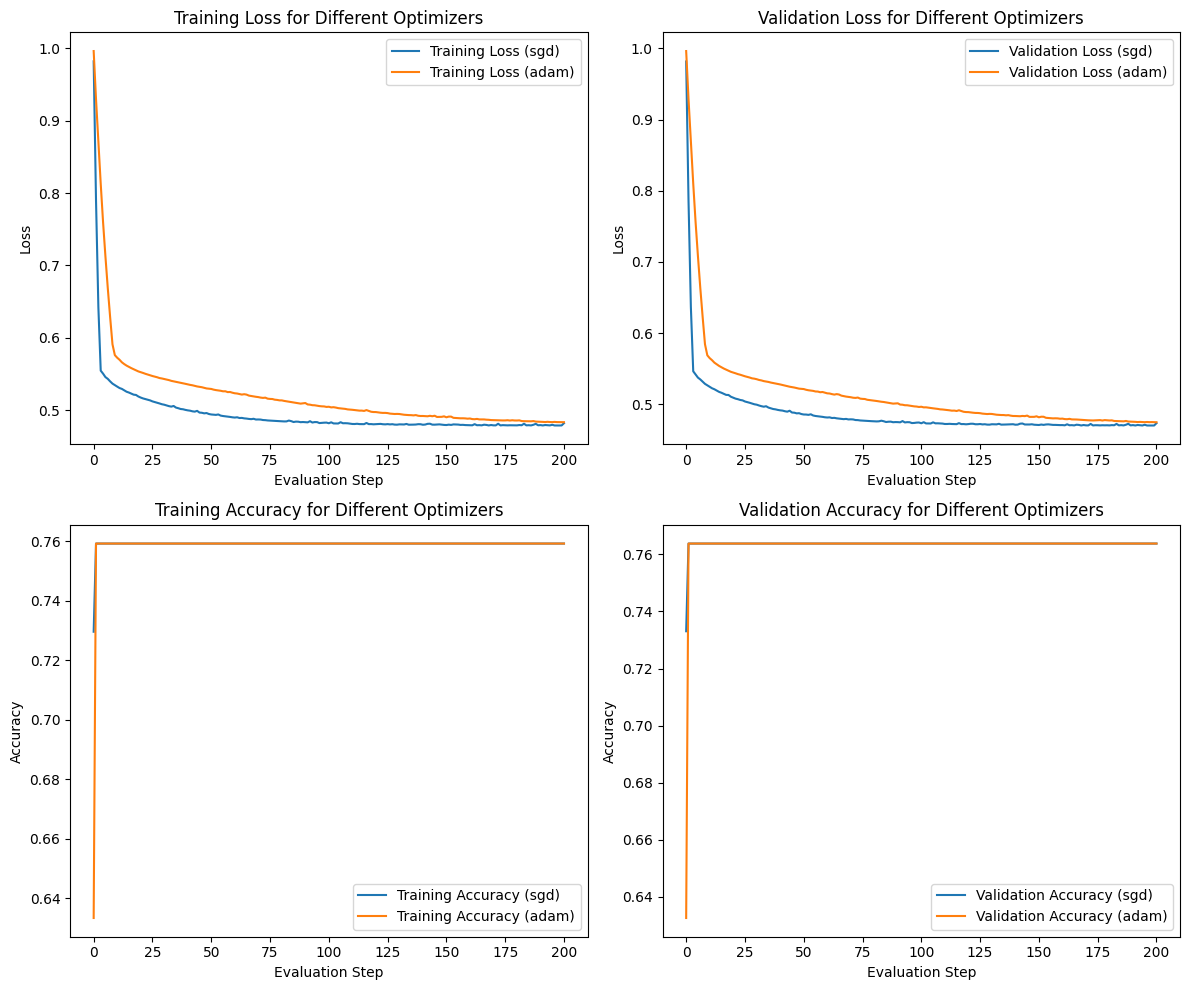

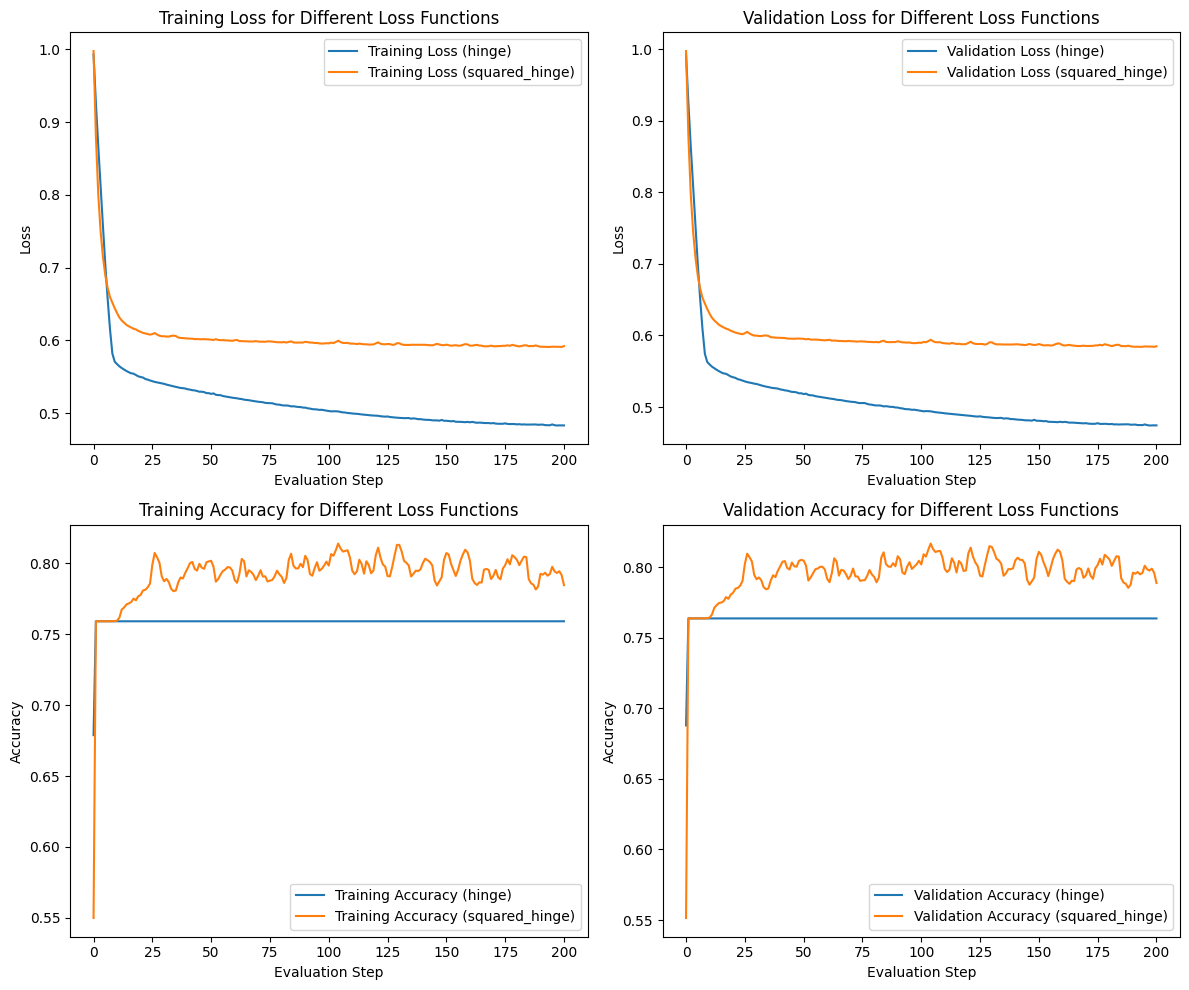

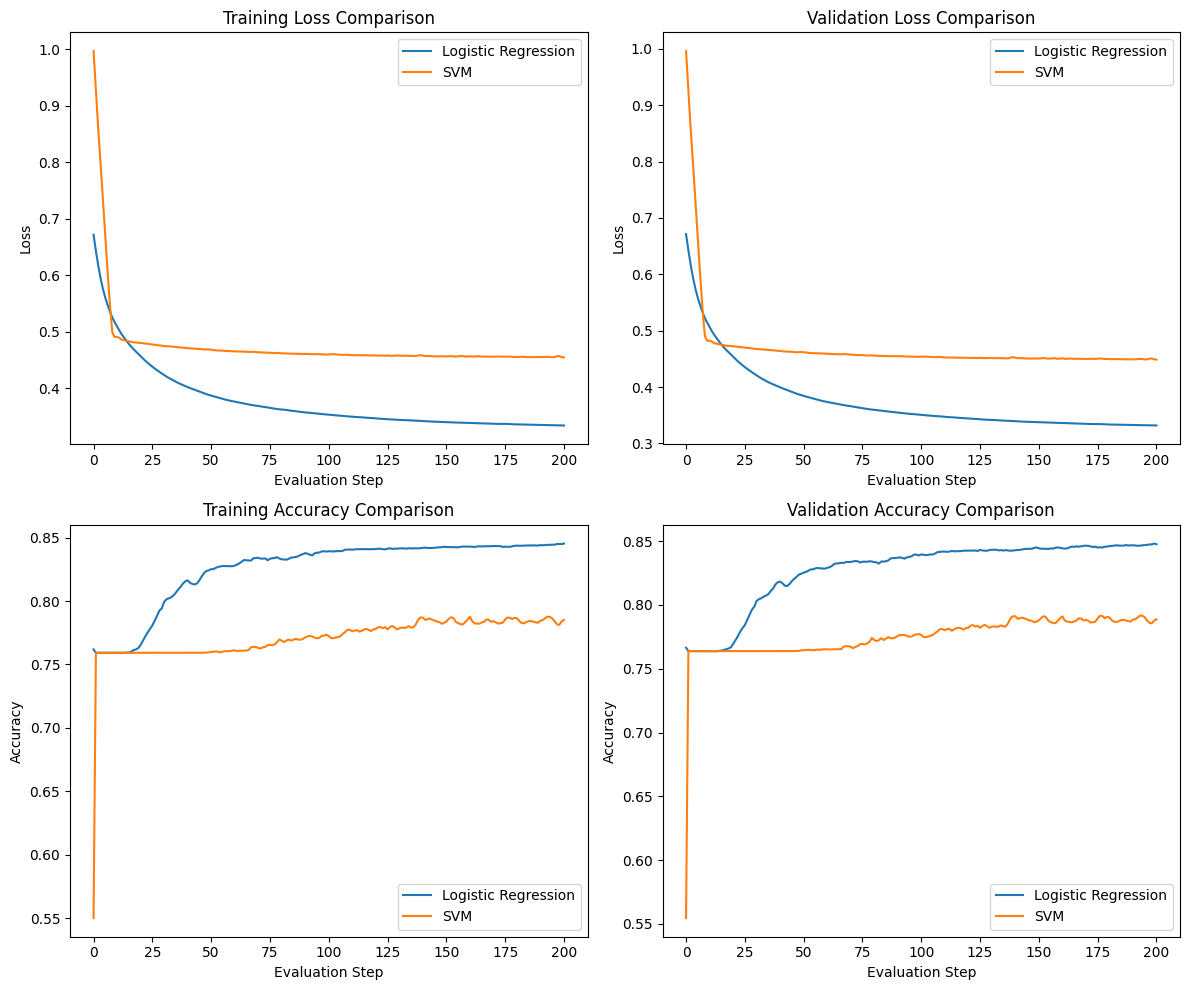

In [41]:
# 运行所有实验

def run_all_experiments():
    """
    运行所有实验
    """
    start_time = time.time()
    
    # 创建报告目录
    os.makedirs('report/my_report', exist_ok=True)
    
    print("="*50)
    print("开始逻辑回归实验...")
    print("="*50)
    run_logistic_regression_experiment()
    
    print("\n" + "="*50)
    print("开始SVM实验...")
    print("="*50)
    run_svm_experiment()
    
    print("\n" + "="*50)
    print("比较逻辑回归和SVM...")
    print("="*50)
    compare_logistic_regression_and_svm()
    
    end_time = time.time()
    print(f"\n所有实验完成！总用时: {(end_time - start_time) / 60:.2f} 分钟")

# 运行实验
if __name__ == "__main__":
    run_all_experiments()
